In [1]:
# setwd("./../utils")
source("../utils/graficos.r")
source("../utils/funcoesAuxiliares.r");
loadPackage("quantmod");
loadPackage("quadprog");
library("reshape2")
library("ggplot2")

options(scipen=999);
loadPackage("RCurl");
data <- getURL("http://www.dcc.ufmg.br/~arbex/portfolios/IBOV.csv", ssl.verifypeer=0L, followlocation=1L);
prices = read.csv(text = data, header = TRUE, sep = ",", stringsAsFactors = FALSE);
begin  = which(prices[,1] > 20190000)[1];
end    = which(prices[,1] > 20200000)[1];
os.prices = prices[end:nrow(prices), ];
is.prices = prices[begin:end, ];

## Questão 1

validar que PETR3 é $I(1)$ pelo teste de Dickey-Fuller

In [2]:
loadPackage('tseries')
q1_prices = prices[prices$Date > 20180000 & prices$Date <= 20200000,]

# Validar que petr3 é I(1)
petr3 = q1_prices[['PETR3']]
for (i in 2 : length(petr3)) { if (is.na(petr3[i])) petr3[i] = petr3[i-1]}
cat("PETR3\n")
cat("P-value antes de obter a primeira diferenciação: ", toString(suppressWarnings(adf.test(petr3, alternative = "stationary")[4])))
petr3.i0 = diff(petr3);
cat("\nP-value após a diferenciação: ", toString(suppressWarnings(adf.test(petr3.i0, alternative = "stationary")[4])))

PETR3
P-value antes de obter a primeira diferenciação:  0.0400891095079282
P-value após a diferenciação:  0.01

1. obter todas as séries que podem ser $I(1)$ através de Dickey-Fuller
2. Para tais séries validar qual é o valor de `alpha` e `beta` para $Y = \alpha + \beta X + \epsilon$

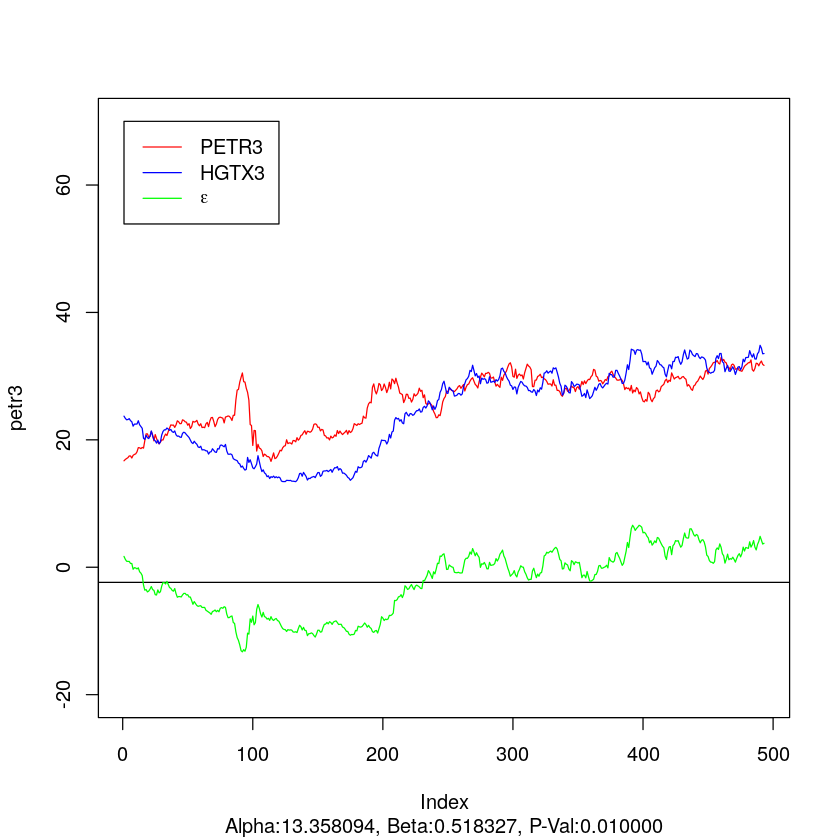

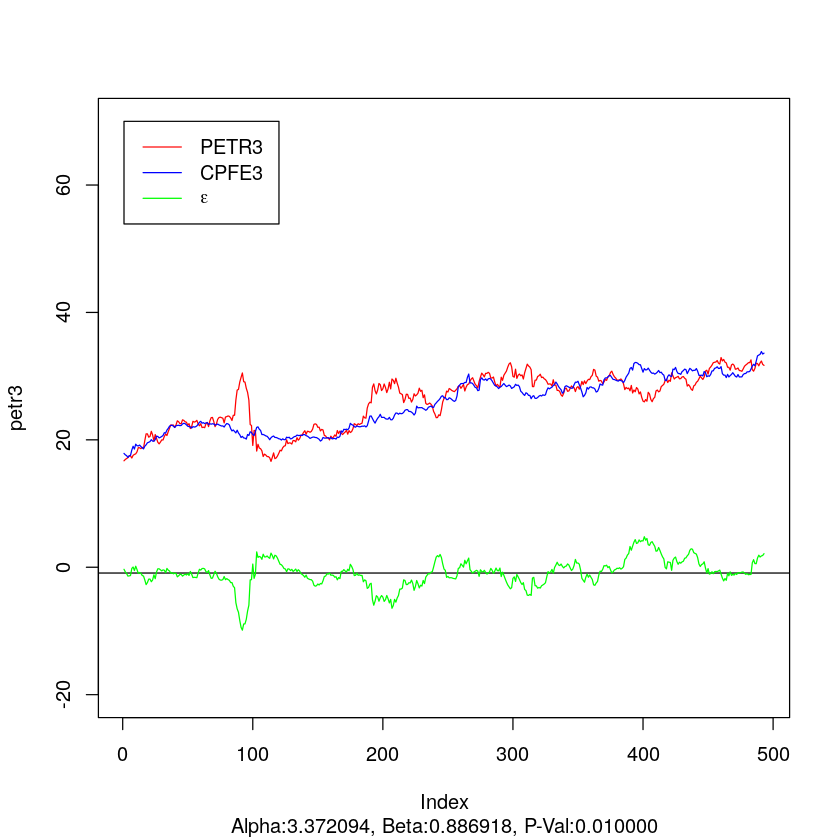

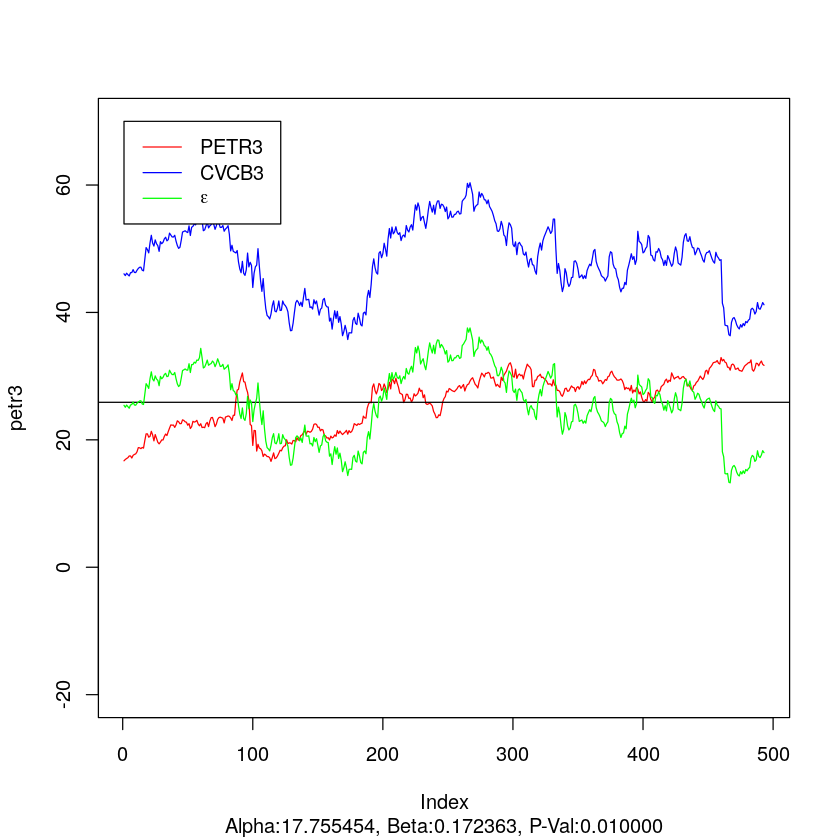

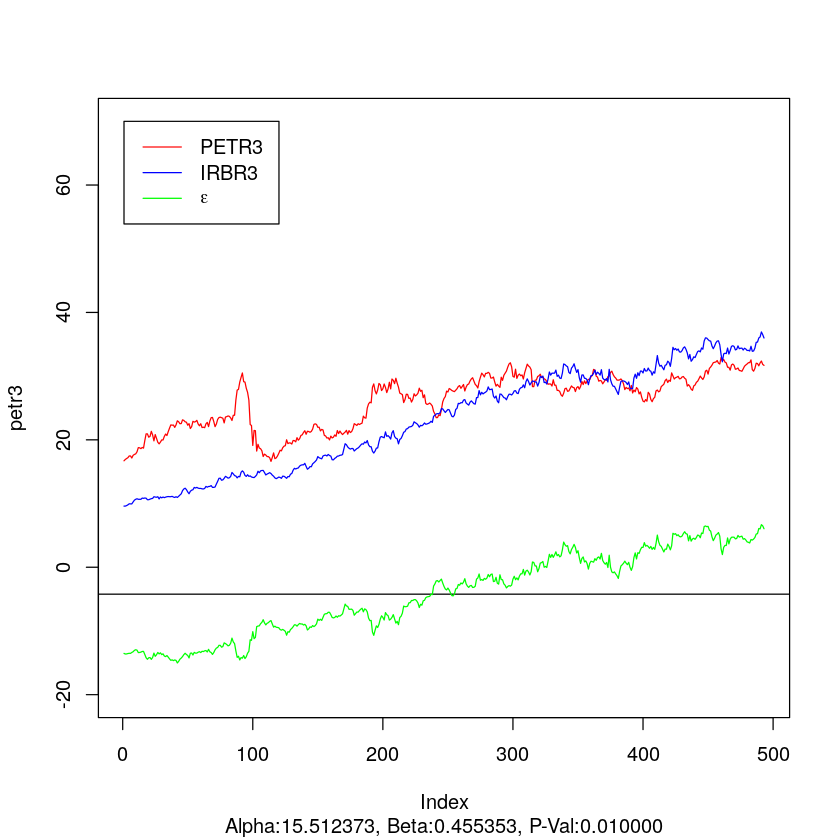

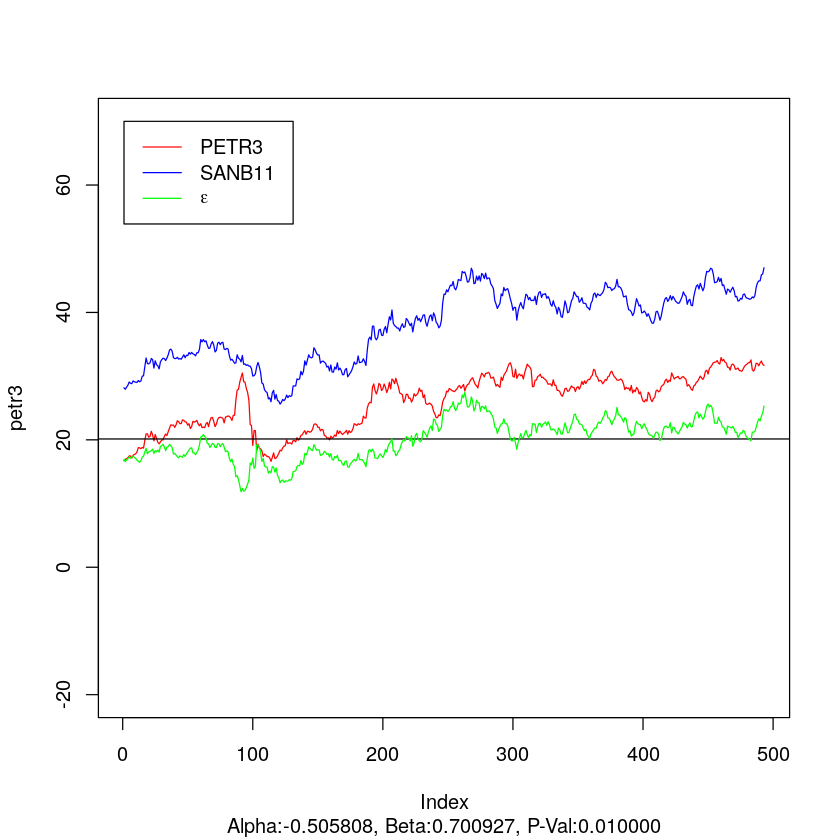

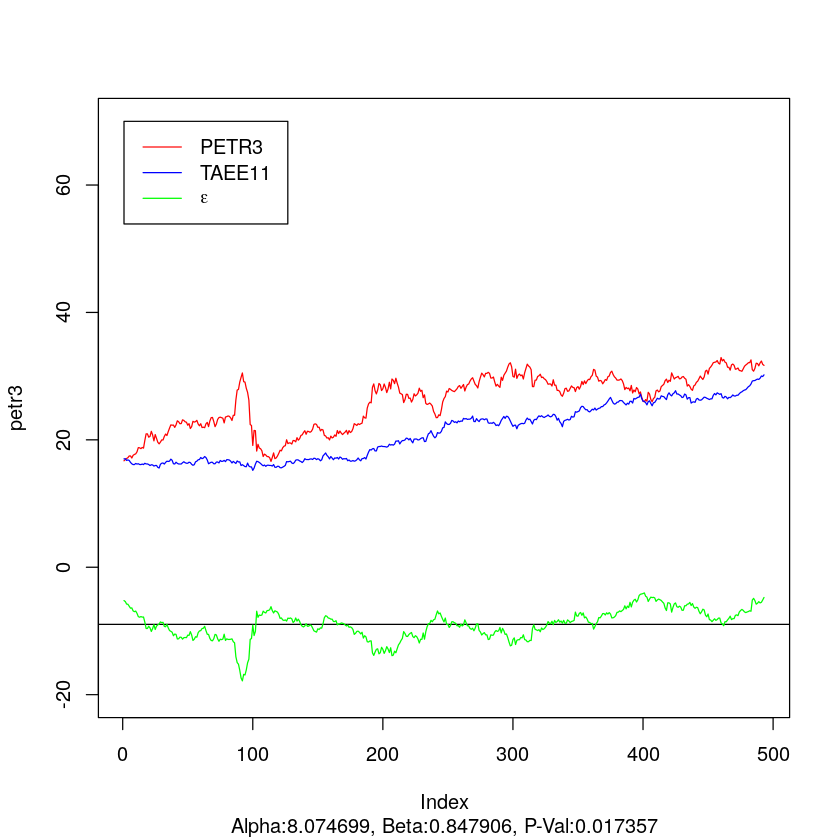

In [3]:
q1_prices$Date <- NULL
q1_prices$PETR3 <- NULL

# Obter todos os ativos que possívelmente são I(1)
i0_prices = data.frame()[1:length(petr3.i0), ]
for(name in colnames(q1_prices)) {
    ativo = q1_prices[[name]]
    for (j in 2 : length(ativo)) { if (is.na(ativo[j])) ativo[j] = ativo[j -1]}
    ativo.i0 = diff(ativo)
    pval.i1 = as.numeric(suppressWarnings(adf.test(ativo, alternative = "stationary")[4]))
    pval.i0 = as.numeric(suppressWarnings(adf.test(ativo.i0, alternative = "stationary")[4]))
    if(pval.i1  <= 0.01 || pval.i0 > 0.01){
        q1_prices[name] <- NULL
    }
}

# encontrando os pares cointegrados com petr3    
show_cointegrated = function(name) {
    Y <- q1_prices[[name]]
    model <- lm(petr3~Y)
    alpha = model$coefficients[1]
    beta = model$coefficients[2]
    epsilon = Y - alpha - (beta*petr3)
    epsilon.pval = as.numeric(suppressWarnings(adf.test(model$residuals, alternative = "stationary")[4]))
    # provavelmente é cointegrado
    if(epsilon.pval <= 0.02){
         
        plot(petr3, type="l", col="red", ylim = c(-20, 70))
        abline(h = mean(epsilon), col="black")
        lines(Y, col="blue")
        lines(epsilon, col="green")
        title(sub=sprintf("Alpha:%f, Beta:%f, P-Val:%f", alpha, beta, epsilon.pval),
              xlab="", ylab="")
        legend(1, 70, legend=c("PETR3",  name, expression(epsilon)),
           col=c("red", "blue", "green"), lty=1, cex=1.)
    }
}
for(name in colnames(q1_prices)) {
    show_cointegrated(name)
}

In [4]:
jpeg("Q1_SANB11.jpg", width = 500, height = 500)
show_cointegrated('SANB11')
dev.off()
jpeg("Q1_IRBR3.jpg", width = 500, height = 500)
show_cointegrated('IRBR3')
dev.off()
jpeg("Q1_CPFE3.jpg", width = 500, height = 500)
show_cointegrated('CPFE3')
dev.off()

png 
  2

png 
  2

png 
  2

### RESPOSTA  1

Considere que na expressão $Y = \alpha+\beta X + \epsilon$, $X$ represente o ativo PETR3 e $Y$ representa um dos ativos escolhidos pela observação do gráfico acima.

Tomando alguns dos valores então observados, temos que:
- SANB11\
  $\alpha=-0.51, \beta=0.70$\
  $Y_{SANB11} = -0.51 + 0.7X_{PETR3} + \epsilon$
- IRBR3\
  $\alpha=15.51, \beta=0.46$\
  $Y_{IRBR3} = 15.51 + 0.46X_{PETR3} + \epsilon$
- CPFE3\
  $\alpha=3.37,\ \beta=0.89$\
  $Y_{CPFE3} = 3.37 + 0.89X_{PETR3} + \epsilon$

Dada tal escolha, e observamos que é possível realizar uma estratégia de pairs trading e obter lucro. Os pesos utilizados nos pares entre PETR3 e o outro ativo se basearia no fator $\beta$ da relação linear, em que com um ativo poderíamos entrar em long, enquanto o outro abriríamos uma posição shorting, a fim de que estas operações neutralizem o risco entre si.
Um exemplo seria realizar shorting em PETR3 e long em SANB11, assim, caso houvesse alguma queda de SANB11, ela seria coberta pela queda de PETR3. Já o prejuízo dado por uma possível aumento em PETR3, seria (mesmo que em partes) neutralizado pelo aumento também em SANB11.

Os gráficos correspondentes a estes ativos são mostrados a seguir:

![sanb](./Q1_SANB11.jpg)
![irbr](./Q1_IRBR3.jpg)
![cpfe](./Q1_CPFE3.jpg)

## Questão 2

In [5]:
insample = prices[prices$Date > 20190000 & prices$Date <= 20200000,]
outsample = prices[prices$Date > 20200000,]

# removendo as colunas 'Date' e 'IBOV'
insample.prices = is.prices[,3:ncol(insample)];
outsample.prices = os.prices[,3:ncol(outsample)];

# calculo da matriz de retornos simples
insample.returns = apply(insample.prices, 2, function(x){diff(x)/x[-length(x)]} );
outsample.returns = apply(insample.prices, 2, function(x){diff(x)/x[-length(x)]} );

# calculo do vetor de retornos esperados (mu) e matriz de covariancias (Sigma)
insample.mu = matrix(colMeans(insample.returns), nrow=1)
colnames(insample.mu) = colnames(insample.returns);
insample.Sigma = cov(insample.returns);


### 2.a
Obtendo o portifólio de variância mínima

In [6]:
q2a.topo  = cbind(2*insample.Sigma, rep(1, nrow(insample.Sigma)));
q2a.fundo = c(rep(1, ncol(insample.Sigma)), 0);
q2a.A = rbind(q2a.topo, q2a.fundo);
q2a.b = c(rep(0, nrow(insample.Sigma)), 1);

p1.z = solve(q2a.A) %*% q2a.b;
p1.weights = p1.z[1:ncol(insample.Sigma),1];

# print(length(p1.weights))
p1.mu = as.numeric(crossprod(p1.weights, as.vector(insample.mu)))

p1.sigma2 = as.numeric(t(p1.weights) %*% insample.Sigma %*% p1.weights);
p1.sigma = sqrt(p1.sigma2)
p1.chart.data <- p1.weights[p1.weights >= 0.0001 || p1.weights <= -0.0001]

In [7]:
cat("p1.mu =",p1.mu)
cat("\np1.sigma =",p1.sigma)

ggOptions = getGGOptions();
ggOptions$barChart = 1;
ggOptions$height = 6;
ggOptions$width = 10;
ggOptions$axisTitleSize = 16;
ggOptions$axisXLabelSize = 8;
ggOptions$axisYLabelSize = 14;
ggOptions$xTitle = "Ativo";
ggOptions$yTitle = "Peso";
ggOptions$percentageInYAxis = 1;
ggOptions$axisXLabelAngle = 90;
ggOptions$title = "Pesos do portfolio p1";
ggOptions$saveGraphics = 1;
ggOptions$imageName = "Q2A.png";
plotGraph(p1.chart.data, xValues = names(p1.chart.data), ggOptions = ggOptions)

p1.mu = 0.001154278
p1.sigma = 0.006071116

null device 
          1

### Resposta 2.a

Sumarizando as ações feitas anteriormente e a obtenção dos resultados, temos que:
   - $\mu_{p1} = 0.001154278$
   - $\sigma_{p1} = 0.006071116$

O gráfico dos pesos também é dado acima, e podemos observar que o range máximo em que os pesos do portifólio de variância mínima global está aproximadamente entre $(-2, 2)$.\
![resultado](./Q2A.png)

### 2.b

resolver o problema de minimização, com adicionando a restrição de que os pesos $w_i$ são maiores ou iguais a $0$.

In [8]:
N = ncol(insample.returns)
q2b.D = insample.Sigma; # Q do modelo
q2b.d = rep(0, N);      # c do modelo
q2b.A = matrix(c(rep(1, N),
                insample.mu, 
                diag(N)),
              ncol = N, 
              byrow = TRUE);
q2b.b = c(1, 0, rep(0, N));
q2b.meq  = 1;

q2b.result <- solve.QP(Dmat = q2b.D, dvec = q2b.d, Amat=t(q2b.A), bvec=q2b.b, meq=q2b.meq);

p2.weights = q2b.result$solution

names(p2.weights) <- colnames(insample.prices)
p2.mu = as.numeric(crossprod(p2.weights, as.vector(insample.mu)))
p2.sigma2 = (q2b.result$val)*2
p2.sigma = sqrt(p2.sigma2)

p2.chart.data <- p2.weights[p2.weights>= 0.0001]

In [9]:
cat("p2.mu =",p2.mu)
cat("\np2.sigma =",p2.sigma)

ggOptions$imageName = "Q2B.png";
ggOptions$title = "Pesos do portfolio p2";
plotGraph(p2.chart.data, xValues = names(p2.chart.data), ggOptions = ggOptions)

p2.mu = 0.001592584
p2.sigma = 0.007689997

null device 
          1

### Resposta 2.b

   - $\mu_{p2} = 0.001592584$
   - $\sigma_{p2} = 0.007689997$

Assim como especificado pela restrição do problema de minimização, temos que aqui os ativos devem conter apenas pesos maiores ou iguais a $0$. é possivel observar, ainda, que o maior peso é de cerca de $17\%$.

![resultado](./Q2B.png)